In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Data Loading and Transformations

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import log_loss

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as torchvision_models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Settings and configurations
class Config:
    dataset = 'CIFAR10'
    batch_size = 128
    num_workers = 4
    model_name = 'resnet18'
    pretrained = False
    use_test = True
    max_num_models = 20
    swag_freq = 5  # Collect every 5 epochs
    swag_samples = 30
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 30

# Transforms and DataLoader Initialization for the original CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers)
testloader = DataLoader(testset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

# Gaussian blur transformations for the blurred CIFAR-10 datasets
blur_transforms = {
    'light': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=0.5), transforms.ToTensor()]),
    'medium': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=1.0), transforms.ToTensor()]),
    'heavy': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=2.0), transforms.ToTensor()])
}

# Create blurred test datasets
blurred_testsets = {
    level: torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    for level, transform in blur_transforms.items()
}

# Create blurred test loaders
blurred_testloaders = {
    level: DataLoader(dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    for level, dataset in blurred_testsets.items()
}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


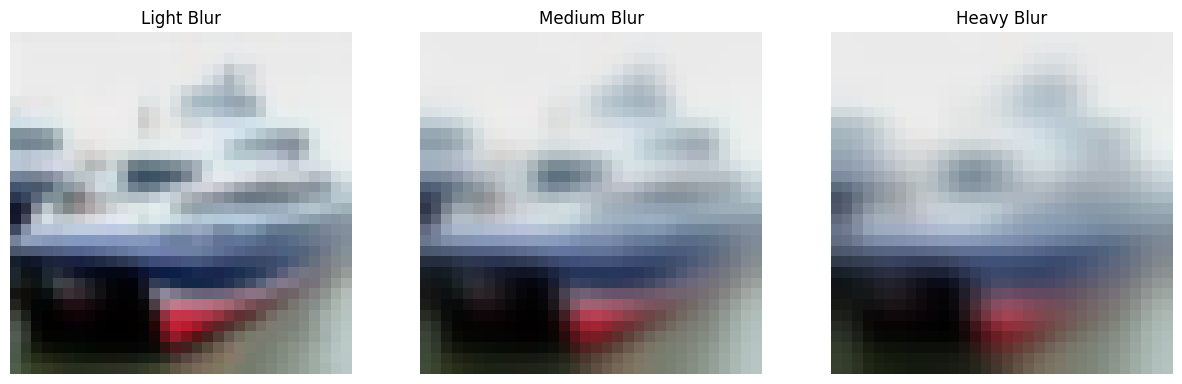

In [12]:
import matplotlib.pyplot as plt
from torchvision import transforms

# Update indices to select different images for each level
images = {
    'light': blurred_testsets['light'][1][0],  # Change indices as needed to select different images
    'medium': blurred_testsets['medium'][1][0],
    'heavy': blurred_testsets['heavy'][1][0]
}

# Convert tensors to PIL images for displaying (necessary to plot with imshow)
to_pil = transforms.ToPILImage()
images_to_display = [to_pil(images[level]) for level in ['light', 'medium', 'heavy']]

# Plotting the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Increased figure size for better visibility
labels = ['Light Blur', 'Medium Blur', 'Heavy Blur']
for ax, img, lbl in zip(axs, images_to_display, labels):
    ax.imshow(img)
    ax.set_title(lbl)
    ax.axis('off')  # Hide axes for a cleaner presentation
plt.show()

# Final Results

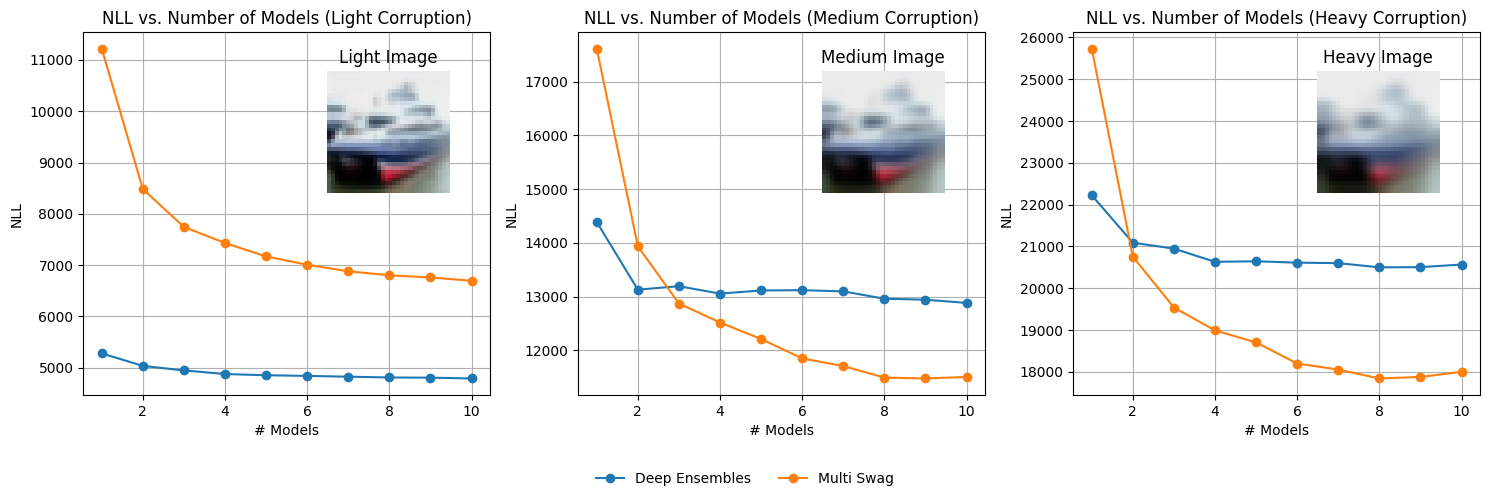

In [4]:
import matplotlib.pyplot as plt
from torchvision import transforms

# NLL data for each level of blur
nll_data = {
    'light': [5278.945, 5035.896, 4946.806, 4877.876, 4852.9966, 4840.8584, 4824.736, 4810.1025, 4805.7373, 4790.665],
    'medium': [14386.7656, 13127.416, 13192.074, 13053.315, 13112.65, 13117.619, 13095.448, 12958.928, 12940.623, 12880.335],
    'heavy': [22223.3809, 21089.822, 20947.29, 20631.832, 20645.37, 20612.05, 20600.916, 20500.283, 20504.84, 20566.967]
}
ensemble_nll_data = {
    'light':[11217.637, 8481.545, 7744.456, 7430.4204, 7169.99, 7007.3984, 6880.3584, 6801.716, 6759.3486, 6695.2607],
    'medium': [17614.764, 13934.449, 12869.195, 12515.346, 12208.555, 11846.072, 11704.497, 11490.144, 11473.371, 11502.004],
    'heavy': [25728.617, 20754.98, 19538.945, 18991.52, 18703.586, 18198.537, 18055.906, 17842.186, 17878.336, 18000.768]
}
model_numbers = list(range(1, 11))  # Model numbers from 1 to 10

# Assuming 'blurred_testsets' is available with images for each blur level
images = {
    'light': blurred_testsets['light'][1][0],
    'medium': blurred_testsets['medium'][1][0],
    'heavy': blurred_testsets['heavy'][1][0]
}

# Convert tensors to PIL images for displaying
to_pil = transforms.ToPILImage()
images_to_display = {level: to_pil(images[level]) for level in ['light', 'medium', 'heavy']}

# Plotting NLL values and the respective images for each blur level
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the overall figure size
for ax, level in zip(axs, ['light', 'medium', 'heavy']):
    ax.plot(model_numbers, nll_data[level], marker='o', linestyle='-', label='Deep Ensembles')
    ax.plot(model_numbers, ensemble_nll_data[level], marker='o', linestyle='-', label='Multi Swag')
    ax.set_title(f'NLL vs. Number of Models ({level.capitalize()} Corruption)')
    ax.set_xlabel('# Models')
    ax.set_ylabel('NLL')
    ax.grid(True)

    # Aspect ratio to make plots more square
    ax.set_aspect(aspect='auto', adjustable='box')

    # Inset image
    inset_ax = ax.inset_axes([0.6, 0.5, 0.30, 0.45])
    inset_ax.imshow(images_to_display[level])
    inset_ax.set_title(f'{level.capitalize()} Image')
    inset_ax.axis('off')

plt.tight_layout()
fig.legend(['Deep Ensembles', 'Multi Swag'], loc='lower center', ncol=2, borderaxespad=0.5, frameon=False)
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin to make room for the legend
plt.show()

## Stochastic Weight Averaging-Gaussian (SWAG) Implementation

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as torchvision_models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Settings and configurations
class Config:
    dataset = 'CIFAR10'
    batch_size = 100
    num_workers = 4
    model_name = 'resnet18'
    pretrained = False
    use_test = True
    max_num_models = 5  # Maximum models to collect
    swag_freq = 5  # Frequency of collection per epoch
    swag_samples = [5, 3, 1]  # Models to use for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 20  # Total epochs to collect enough models

# Transforms and DataLoader Initialization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers)
testloader = DataLoader(testset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

# Gaussian blur transformations for the blurred CIFAR-10 datasets
blur_transforms = {
    'light': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=0.5), transforms.ToTensor()]),
    'medium': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=1.0), transforms.ToTensor()]),
    'heavy': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=2.0), transforms.ToTensor()])
}
blurred_testsets = {
    level: torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    for level, transform in blur_transforms.items()
}
blurred_testloaders = {
    level: DataLoader(dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    for level, dataset in blurred_testsets.items()
}

# Training and Evaluation Functions
def train_epoch(loader, model, criterion, optimizer, device, swag_model=None, collect=False, epoch=None):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss, outputs, _ = criterion(model, inputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch {epoch}, Batch {i + 1}/{total_batches}, Loss: {running_loss / (i + 1):.4f}')

        if collect and (i + 1) % Config.swag_freq == 0:
            swag_model.collect_model(model)
            if swag_model.n_models.item() == Config.max_num_models:
                break  # Stop collecting after max models reached

def evaluate(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    return accuracy

# Plotting function
def plot_accuracies(acc_results):
    fig, ax = plt.subplots()
    for level in ['light', 'medium', 'heavy']:
        models = sorted(acc_results[level].keys())
        accuracies = [acc_results[level][model] for model in models]
        ax.plot(models, accuracies, marker='o', label=f'{level} blur')

    ax.set_xlabel('Number of Models')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model Accuracy by Blur Level and Number of Models')
    ax.legend()
    plt.grid(True)
    plt.show()

# Main Execution Logic
def main():
    model = torchvision_models.__dict__[Config.model_name](pretrained=Config.pretrained)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.to(Config.device)

    swag_model = SWAG(model)
    swag_model.to(Config.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(base_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

    # Training and collecting models
    print("Starting training and model collection...")
    for epoch in range(Config.epochs):
        train_epoch(trainloader, model, criterion, optimizer, Config.device, swag_model, collect=True, epoch=epoch+1)
        if swag_model.n_models.item() == Config.max_num_models:
            break

    # Evaluating SWAG model on different numbers of collected models
    acc_results = {level: {} for level in ['light', 'medium', 'heavy']}
    for num_models in Config.swag_samples:
        swag_model.reset()
        print(f"Evaluating with {num_models} models...")
        for level, loader in blurred_testloaders.items():
            swag_model.sample(scale=0.5)
            accuracy = evaluate(swag_model, loader, Config.device)
            acc_results[level][num_models] = accuracy
            print(f"{level.capitalize()} Blur, {num_models} Models: {accuracy:.2f}% Accuracy")

    plot_accuracies(acc_results)

if __name__ == "__main__":
    main()


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


NameError: name 'base_model' is not defined

## SWAG Helper Functions

In [15]:
def save_checkpoint(dir, epoch, name='checkpoint', **kwargs):
    state = {
        'epoch': epoch,
    }
    state.update(kwargs)
    filepath = os.path.join(dir, '%s-%d.pt' % (name, epoch))
    torch.save(state, filepath)

def set_weights(model, vector, device=None):
    offset = 0
    for param in model.parameters():
        param.data.copy_(vector[offset:offset + param.numel()].view(param.size()).to(device))
        offset += param.numel()


def nll(outputs, labels):
    labels = labels.astype(int)
    idx = (np.arange(labels.size), labels)
    ps = outputs[idx]
    nll = -np.sum(np.log(ps))
    return nll

def accuracy(outputs, labels):
    return (np.argmax(outputs, axis=1) == labels).mean()

def train_epoch(loader, model, criterion, optimizer, cuda=True, regression=False, verbose=False, subset=None,
                regularizer=None):
    loss_sum = 0.0
    stats_sum = defaultdict(float)
    correct = 0.0
    verb_stage = 0

    num_objects_current = 0
    num_batches = len(loader)

    model.train()

    if subset is not None:
        num_batches = int(num_batches * subset)
        loader = itertools.islice(loader, num_batches)

    if verbose:
        loader = tqdm.tqdm(loader, total=num_batches)

    for i, (input, target) in enumerate(loader):
        if cuda:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

        loss, output, stats = criterion(model, input, target)
        if regularizer:
            loss += regularizer(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.data.item() * input.size(0)
        for key, value in stats.items():
            stats_sum[key] += value * input.size(0)

        if not regression:
            pred = output.data.argmax(1, keepdim=True)
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        num_objects_current += input.size(0)

        if verbose and 10 * (i + 1) / num_batches >= verb_stage + 1:
            print('Stage %d/10. Loss: %12.4f. Acc: %6.2f' % (
                verb_stage + 1, loss_sum / num_objects_current,
                correct / num_objects_current * 100.0
            ))
            verb_stage += 1

    return {
        'loss': loss_sum / num_objects_current,
        'accuracy': None if regression else correct / num_objects_current * 100.0,
        'stats': {key: value / num_objects_current for key, value in stats_sum.items()}
    }


def eval(loader, model, criterion, cuda=True, regression=False, verbose=False, eval=True):
    loss_sum = 0.0
    correct = 0.0
    stats_sum = defaultdict(float)
    num_objects_total = len(loader.dataset)

    model.train(not eval)
    with torch.no_grad():
        if verbose:
            loader = tqdm.tqdm(loader)
        for i, (input, target) in enumerate(loader):
            if cuda:
                input = input.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)

            loss, output, stats = criterion(model, input, target)

            loss_sum += loss.item() * input.size(0)
            for key, value in stats.items():
                stats_sum[key] += value

            if not regression:
                pred = output.data.argmax(1, keepdim=True)
                correct += pred.eq(target.data.view_as(pred)).sum().item()

    return {
        'loss': loss_sum / num_objects_total,
        'accuracy': None if regression else correct / num_objects_total * 100.0,
        'stats': {key: value / num_objects_total for key, value in stats_sum.items()}
    }

def predict(loader, model, verbose=False):
    predictions = list()
    targets = list()

    model.eval()

    if verbose:
        loader = tqdm.tqdm(loader)

    offset = 0
    with torch.no_grad():
        for input, target in loader:
            input = input.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            target = target.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            input = input.cuda(non_blocking=True)
            output = model(input)

            batch_size = input.size(0)
            predictions.append(F.softmax(output, dim=1).cpu().numpy())
            targets.append(target.cpu().numpy())
            offset += batch_size

    return {
        'predictions': np.vstack(predictions),
        'targets': np.concatenate(targets)
    }

In [1]:
import torch
import itertools
import tqdm

def bn_update(loader, model, verbose=False, subset=None, **kwargs):
    flag = [False]
    model.apply(lambda module: flag.__setitem__(0, True) if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm) else None)
    if not flag[0]:
        return

    model.train()
    momenta = {}

    model.apply(lambda module: [setattr(module, 'running_mean', torch.zeros_like(module.running_mean)) or setattr(module, 'running_var', torch.ones_like(module.running_var)) if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm) else None])

    model.apply(lambda module: momenta.__setitem__(module, module.momentum) if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm) else None)

    n = 0
    num_batches = len(loader)

    with torch.no_grad():
        if subset is not None:
            num_batches = int(num_batches * subset)
            loader = itertools.islice(loader, num_batches)
        if verbose:
            loader = tqdm.tqdm(loader, total=num_batches)

        for input, _ in loader:
            input = input.cuda(non_blocking=True)
            input_var = torch.autograd.Variable(input)
            b = input_var.data.size(0)

            momentum = b / (n + b)
            for module in momenta.keys():
                module.momentum = momentum

            model(input_var, **kwargs)
            n += b

    # Restore original momenta for all batch norm layers
    model.apply(lambda module: setattr(module, 'momentum', momenta[module]) if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm) else None)

## Stochastic Weight Averaging-Gaussian (SWAG) Implmentation

In [16]:
import torch
import torch.nn as nn

class SWAG(nn.Module):
    def __init__(self, base_model, variance_clamp=1e-6, max_rank=20):
        super().__init__()
        self.base_model = base_model
        self.num_parameters = sum(p.numel() for p in base_model.parameters())
        self.max_rank = max_rank
        self.variance_clamp = variance_clamp
        self.model_device = torch.device('cpu')  # Use CPU for Mac

        self.register_buffer('mean', torch.zeros(self.num_parameters))  
        self.register_buffer('square_mean', torch.zeros(self.num_parameters))  
        self.register_buffer('num_collected_models', torch.zeros(1, dtype=torch.long))
        self.register_buffer('rank', torch.zeros(1, dtype=torch.long))
        self.register_buffer('cov_mat_sqrt', torch.empty(0, self.num_parameters, dtype=torch.float32))
        self.covariance_factor = None

    def forward(self, *args, **kwargs):
        return self.base_model(*args, **kwargs)

    def collect_model(self, model_instance):
        flat_params = torch.cat([p.detach().cpu().view(-1) for p in model_instance.parameters()])
        num_collected = self.num_collected_models.item() + 1

        self.mean = (self.mean * ((num_collected - 1) / num_collected)) + (flat_params / num_collected)
        self.square_mean = (self.square_mean * ((num_collected - 1) / num_collected)) + (flat_params.pow(2) / num_collected)

        if self.rank.item() >= self.max_rank:
            self.cov_mat_sqrt = self.cov_mat_sqrt[1:]
        self.cov_mat_sqrt = torch.cat((self.cov_mat_sqrt, (flat_params - self.mean).unsqueeze(0)), dim=0)
        self.rank = torch.clamp(self.rank + 1, max=self.max_rank)
        self.num_collected_models += 1

    def _get_mean_and_variance(self):
        variance = torch.clamp(self.square_mean - self.mean.pow(2), self.variance_clamp)
        return self.mean, variance

    def fit(self):
        if self.covariance_factor is None:
            self.covariance_factor = self.cov_mat_sqrt.clone() / (self.cov_mat_sqrt.size(0) - 1) ** 0.5

    def set_swa(self):
        self._set_weights(self.mean)

    def sample(self, scale=0.5, diagonal_noise=True):
        self.fit()
        mean, variance = self._get_mean_and_variance()
        low_rank_noise = torch.randn(self.covariance_factor.size(0), device=self.model_device)
        scaled_noise = self.covariance_factor.t().matmul(low_rank_noise)

        if diagonal_noise:
            scaled_noise += variance.sqrt() * torch.randn_like(variance)

        self._set_weights(mean + scaled_noise * scale.sqrt())
        return mean + scaled_noise * scale.sqrt()

    def _set_weights(self, weights):
        offset = 0
        for param in self.base_model.parameters():
            param_length = param.numel()
            param.data.copy_(weights[offset:offset + param_length].view(param.size()))
            offset += param_length

We have created a simple test to check to see if SWAG IS working. 

In [22]:
from torch.utils.data import DataLoader, Subset
import pandas as pd
import time
import torchvision.models as models

# Testing function
def train_swag_test():
    # Configuration
    class Config:
        dataset = 'CIFAR10'
        batch_size = 64
        num_workers = 2
        model_name = 'SimpleNN'
        use_test = True
        max_num_models = 3
        swag_freq = 5
        save_freq = 10
        swag_samples = 5
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        epochs = 5
        swag_start = 3
        lr_init = 0.01
        momentum = 0.9
        wd = 1e-4
        eval_freq = 2

    # Transforms and DataLoader Initialization
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create subsets for quick testing
    small_trainset = Subset(trainset, range(50))  # Use only 500 samples for training
    small_testset = Subset(testset, range(10))   # Use only 100 samples for testing

    trainloader = DataLoader(small_trainset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers)
    testloader = DataLoader(small_testset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

    # Model Initialization
    base_model = models.resnet18(pretrained=False)
    base_model.fc = nn.Linear(base_model.fc.in_features, 10)  # Adjust for CIFAR-10
    base_model.to(Config.device)

    # SWAG Model Initialization
    swag_model = SWAG(base_model, max_rank=Config.max_num_models)
    swag_model.to(Config.device)

    optimizer = optim.SGD(base_model.parameters(), lr=Config.lr_init, momentum=Config.momentum, weight_decay=Config.wd)

    criterion = nn.CrossEntropyLoss()

    def train_epoch_local(loader, model, criterion, optimizer):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in loader:
            inputs, targets = inputs.to(Config.device), targets.to(Config.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        return running_loss / total, 100. * correct / total

    def eval(loader, model, criterion):
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(Config.device), targets.to(Config.device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        return running_loss / total, 100. * correct / total

    results = []

    for epoch in range(Config.epochs):
        epoch_start_time = time.time()
        train_loss, train_acc = train_epoch_local(trainloader, base_model, criterion, optimizer)
        test_loss, test_acc = eval(testloader, base_model, criterion)

        swag_loss, swag_acc = None, None
        if (epoch + 1) >= Config.swag_start:
            swag_model.collect_model(base_model)

            if epoch % Config.eval_freq == 0 or epoch == Config.epochs - 1:
                swag_model.set_swa()
                swag_loss, swag_acc = eval(testloader, swag_model, criterion)
                print(f'SWAG Evaluation - Epoch: {epoch + 1}, Loss: {swag_loss:.4f}, Accuracy: {swag_acc:.2f}%')

        epoch_duration = time.time() - epoch_start_time
        results.append([
            epoch + 1,
            train_loss,
            train_acc,
            test_loss,
            test_acc,
            swag_loss,
            swag_acc,
            epoch_duration
        ])

    results_df = pd.DataFrame(results, columns=['Epoch', 'Train Loss', 'Train Acc', 'Test Loss', 'Test Acc', 'SWAG Loss', 'SWAG Acc', 'Time'])

    print("SWAG training and testing complete.")
    return results_df

In [23]:
results_df = train_swag_test()
results_df

Files already downloaded and verified
Files already downloaded and verified


/Users/advaykoranne/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/advaykoranne/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SWAG Evaluation - Epoch: 3, Loss: 2.3114, Accuracy: 20.00%
SWAG Evaluation - Epoch: 5, Loss: 2.3513, Accuracy: 10.00%
SWAG training and testing complete.


,Epoch,Train Loss,Train Acc,Test Loss,Test Acc,SWAG Loss,SWAG Acc,Time
0,1,2.365440,14.0,2.257615,30.0,NaN,NaN,15.385596
1,2,2.115642,20.0,2.286556,10.0,NaN,NaN,15.942956
2,3,1.534209,62.0,2.311427,20.0,2.311427,20.0,22.639081
3,4,1.053512,84.0,2.372584,10.0,NaN,NaN,15.390498
4,5,0.501730,100.0,2.430807,0.0,2.351336,10.0,23.294618


Training the SWAG models

In [24]:
import tabulate

def train_swag(ckpt_directory):
    class Config:
        dataset = 'CIFAR10'
        batch_size = 100
        num_workers = 4
        model_name = 'resnet18'
        pretrained = False
        use_test = True
        max_num_models = 5  # Maximum models to collect
        swag_freq = 5  # Frequency of collection per epoch
        save_freq = 10  # Frequency of collection per epoch
        swag_samples = 15  # Models to use for testing
        # device = torch.device('cpu')
        epochs = 40  # Total epochs to collect enough models
        swag_start = 20
        lr_init = 0.1  # Initial learning rate
        momentum = 0.9  # Momentum for SGD
        wd = 5e-4  # Weight decay for SGD
        eval_freq = 5
        dir = ckpt_directory
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Transforms and DataLoader Initialization
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])

    print('Loading dataset %s' % Config.dataset)
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers)
    testloader = DataLoader(testset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

    print('Using model %s' % Config.model_name)

    print('Preparing directory %s' % Config.dir)
    os.makedirs(Config.dir, exist_ok=True)
    with open(os.path.join(Config.dir, 'command.sh'), 'w') as f:
        f.write(' '.join(sys.argv))
        f.write('\n')
    print('Preparing model')

    base_model = models.resnet18(pretrained=Config.pretrained)
    base_model.fc = nn.Linear(base_model.fc.in_features, 10)  # Adjust for CIFAR-10
    base_model.to(Config.device)

    print('SWAG training')
    # SWAG Model Initialization
    swag_model = SWAG(base_model, max_rank=Config.max_num_models)
    swag_model.to(Config.device)

    optimizer = optim.SGD(base_model.parameters(), lr=Config.lr_init, momentum=Config.momentum, weight_decay=Config.wd)

    def cross_entropy_loss(model, inputs, targets):
        outputs = model(inputs)
        loss = nn.functional.cross_entropy(outputs, targets)
        return loss, outputs, {}

    criterion = cross_entropy_loss

    num_ensembled_models = 0.0

    columns = ['Epoch', 'LR', 'Train Loss', 'Train Acc', 'Test Loss', 'Test Acc', 'Time']

    for epoch in range(0, Config.epochs):
        epoch_start_time = time.time()
        print()

        # train_results = train_epoch(trainloader, base_model, criterion, optimizer)

        if epoch == 0 or epoch % Config.eval_freq == Config.eval_freq - 1 or epoch == Config.epochs - 1:
            test_results = eval(trainloader, base_model, criterion,Config.device)
        else:
            test_results = {'loss': None, 'accuracy': None}

        if (epoch + 1) > Config.swag_start:
            swag_model.collect_model(base_model)

            if epoch == 0 or epoch % Config.eval_freq == Config.eval_freq - 1 or epoch == Config.epochs - 1:
                swag_model.set_swa()
                bn_update(trainloader, swag_model)
                swag_results = eval(testloader, swag_model, criterion)

        if (epoch + 1) % Config.save_freq == 0:
            save_checkpoint(
                Config.dir,
                epoch + 1,
                state_dict=base_model.state_dict(),
                optimizer=optimizer.state_dict()
            )
            save_checkpoint(
                Config.dir,
                epoch + 1,
                name='swag',
                state_dict=swag_model.state_dict(),
            )

        epoch_duration = time.time() - epoch_start_time
        epoch_stats = [
            epoch + 1,
            Config.lr_init,
            train_results['loss'],
            train_results['accuracy'],
            test_results['loss'],
            test_results['accuracy'],
            epoch_duration
        ]

        epoch_table = tabulate.tabulate(
            [epoch_stats], columns, tablefmt='simple', floatfmt='8.4f'
        )
        if epoch % 10 == 0:
            epoch_table = epoch_table.split('\n')
            epoch_table = '\n'.join([epoch_table[1]] + epoch_table)
        else:
            epoch_table = epoch_table.split('\n')[2]
        print(epoch_table)

    if Config.epochs % Config.save_freq != 0:
        save_checkpoint(
            Config.dir,
            Config.epochs,
            state_dict=base_model.state_dict(),
            optimizer=optimizer.state_dict()
        )
        if Config.epochs > Config.swag_start:
            save_checkpoint(
                Config.dir,
                Config.epochs,
                name='swag',
                state_dict=swag_model.state_dict(),
            )


In [25]:
for i in range(11):
  train_swag(f"ckpts/swag_{i}_correct")

Loading dataset CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Using model resnet18
Preparing directory ckpts/swag_0_correct
Preparing model
SWAG training



AssertionError: Torch not compiled with CUDA enabled

In [17]:
import torch
import torchvision.models as models
import torch.nn as nn
import os
import sys
import numpy as np
import tabulate

def eval_swag(trainloader, testloader, swag_checkpoints, save_directory):
    class Config:
        dataset = 'CIFAR10'
        batch_size = 100
        num_workers = 4
        model_name = 'resnet18'
        pretrained = False
        use_test = True
        swag_freq = 5
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        epochs = 20
        swag_ckpts = swag_checkpoints
        savedir = save_directory
        swag_samples = 10

    print('Preparing model')
    base_model = models.resnet18(pretrained=Config.pretrained)
    base_model.fc = nn.Linear(base_model.fc.in_features, 10)  # Adjust for CIFAR-10
    base_model.to(Config.device)

    print('SWAG evaluation')
    # SWAG Model Initialization
    swag_model = SWAG(base_model)
    swag_model.to(Config.device)

    print("Model has {} parameters".format(
        sum(param.numel() for param in base_model.parameters())))

    columns = ['SWAG', 'Sample', 'Test Loss', 'Test Acc', 'Ens Loss', 'Ens Acc']

    num_ensembled_models = 0.0
    multiswag_probabilities = None
    ensemble_nll_list = []

    for checkpoint_index, checkpoint_path in enumerate(Config.swag_ckpts):
        print("Checkpoint {}".format(checkpoint_path))
        checkpoint = torch.load(checkpoint_path)
        swag_model.load_state_dict(checkpoint['state_dict'])
        print('Number of ensembled models: ', num_ensembled_models)

        for sample_index in range(Config.swag_samples):
            swag_model.sample(0.5)
            bn_update(trainloader, swag_model)
            evaluation_results = predict(testloader, swag_model)
            probabilities = evaluation_results['predictions']
            targets = evaluation_results['targets']
            nll_value = nll(probabilities, targets)
            accuracy_value = accuracy(probabilities, targets)

            if multiswag_probabilities is None:
                multiswag_probabilities = probabilities.copy()
            else:
                multiswag_probabilities += (probabilities - multiswag_probabilities) / (num_ensembled_models + 1)

            num_ensembled_models += 1

            ensemble_nll = nll(multiswag_probabilities, targets)
            ensemble_accuracy = accuracy(multiswag_probabilities, targets)
            epoch_stats = [
                checkpoint_index,
                sample_index,
                nll_value,
                accuracy_value,
                ensemble_nll,
                ensemble_accuracy
            ]

            epoch_table = tabulate.tabulate(
                [epoch_stats], columns, tablefmt='simple', floatfmt='8.4f'
            )
            print(epoch_table)

        ensemble_nll_list.append(ensemble_nll)

    print('Preparing directory %s' % Config.savedir)
    os.makedirs(Config.savedir, exist_ok=True)
    with open(os.path.join(Config.savedir, 'eval_command.sh'), 'w') as f:
        f.write(' '.join(sys.argv))
        f.write('\n')

    np.savez(os.path.join(Config.savedir, "multiswag_probs.npz"),
             predictions=multiswag_probabilities,
             targets=targets)

    return ensemble_nll_list


In [ ]:
# Transforms and DataLoader Initialization
%cd "/content/drive/MyDrive/4782"

class Config:
    dataset = 'CIFAR10'
    batch_size = 100
    num_workers = 4

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers)
testloader = DataLoader(testset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)

# Gaussian blur transformations for the blurred CIFAR-10 datasets
blur_transforms = {
    'light': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=0.5), transforms.ToTensor()]),
    'medium': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=1.0), transforms.ToTensor()]),
    'heavy': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=2.0), transforms.ToTensor()])
}
blurred_testsets = {
    level: torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    for level, transform in blur_transforms.items()
}
blurred_testloaders = {
    level: DataLoader(dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    for level, dataset in blurred_testsets.items()
}


for level, loader in blurred_testloaders.items():

    ens_nll_list = eval_swag(trainloader, loader,['ckpts/swag_1_correct/swag-40.pt', 'ckpts/swag_2_correct/swag-40.pt', 'ckpts/swag_3_correct/swag-40.pt',
                                                  'ckpts/swag_4_correct/swag-40.pt', 'ckpts/swag_5_correct/swag-40.pt', 'ckpts/swag_6_correct/swag-40.pt',
                                                  'ckpts/swag_7_correct/swag-40.pt', 'ckpts/swag_8_correct/swag-40.pt', 'ckpts/swag_9_correct/swag-40.pt',
                                                  'ckpts/swag_10_correct/swag-40.pt'],
                             "ckpts/eval" )
    print(f"nll at level: {level}, {ens_nll_list})")



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import log_loss

# Configurations
class Config:
    dataset = 'CIFAR10'
    batch_size = 128
    epochs = 10
    num_models = 10
    lr = 0.01
    momentum = 0.9
    weight_decay = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
print("Preparing data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=Config.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=Config.batch_size, shuffle=False)

print("Data preparation completed.")

# Gaussian blur transformations
print("Preparing blurred test loaders...")
blur_transforms = {
    'light': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=0.5), transform]),
    'medium': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=1.0), transform]),
    'heavy': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=2.0), transform])
}

blurred_testloaders = {
    level: DataLoader(torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                                  transform=blur_transforms[level]),
                      batch_size=Config.batch_size, shuffle=False)
    for level in ['light', 'medium', 'heavy']
}

print("Blurred test loaders prepared.")

# Model Training and Evaluation Functions
def train_model():
    print("Training model...")
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.to(Config.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=Config.lr, momentum=Config.momentum, weight_decay=Config.weight_decay)
    for epoch in range(Config.epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(trainloader)
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(Config.device), labels.to(Config.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Print status update for every 10% completion of an epoch
            if (batch_idx + 1) % (total_batches // 10) == 0:
                percent_complete = ((batch_idx + 1) / total_batches) * 100
                print(f"Epoch [{epoch + 1}/{Config.epochs}], {percent_complete:.1f}% complete")

        # Print status update after each epoch
        print(f"Epoch [{epoch + 1}/{Config.epochs}] finished")
    print("Model training completed.")
    return model

def evaluate_ensemble(models_ensemble, loader):
    print("Evaluating ensemble...")
    ensemble_probs = []
    targets = []
    for model in models_ensemble:
        model.eval()
        model_probs = []
        model_targets = []
        with torch.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(Config.device)
                outputs = model(inputs)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                model_probs.append(probabilities.cpu().numpy())
                if model == models_ensemble[0]:  # Collect targets only once
                    model_targets.append(labels.cpu().numpy())
        ensemble_probs.append(np.concatenate(model_probs))
        if model == models_ensemble[0]:
            targets = np.concatenate(model_targets)

    ensemble_probs = np.mean(ensemble_probs, axis=0)
    nll_value = nll(ensemble_probs, targets)
    return nll_value

# Main execution
print("Starting main execution...")
models_ensemble = []
nll_scores = {level: [] for level in ['light', 'medium', 'heavy']}

for i in range(1, Config.num_models + 1):
    print(f"Training model {i}")
    model = train_model()
    models_ensemble.append(model)

    # Evaluate for each blur level
    for level, loader in blurred_testloaders.items():
        print(f"Evaluating ensemble for {level} blur level...")
        nll_score = evaluate_ensemble(models_ensemble, loader)
        nll_scores[level].append(nll_score)
        print(f"NLL at level: {level}, {nll_scores[level]}")

print("Main execution completed.")

Preparing data...
Files already downloaded and verified
Files already downloaded and verified
Data preparation completed.
Preparing blurred test loaders...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Blurred test loaders prepared.
Starting main execution...
Training model 1
Training model...
Epoch [1/10], 10.0% complete
Epoch [1/10], 19.9% complete
Epoch [1/10], 29.9% complete
Epoch [1/10], 39.9% complete
Epoch [1/10], 49.9% complete
Epoch [1/10], 59.8% complete
Epoch [1/10], 69.8% complete
Epoch [1/10], 79.8% complete
Epoch [1/10], 89.8% complete
Epoch [1/10], 99.7% complete
Epoch [1/10] finished
Epoch [2/10], 10.0% complete
Epoch [2/10], 19.9% complete
Epoch [2/10], 29.9% complete
Epoch [2/10], 39.9% complete
Epoch [2/10], 49.9% complete
Epoch [2/10], 59.8% complete
Epoch [2/10], 69.8% complete
Epoch [2/10], 79.8% complete
Epoch [2/10], 89.8% complete
Epoch [2/10], 99.7% complete
Epoch [2/10] finished
Epoch [3/10],

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# Configurations
class Config:
    dataset = 'CIFAR10'
    batch_size = 128
    epochs = 10
    num_models = 10
    lr = 0.01
    momentum = 0.9
    weight_decay = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=Config.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=Config.batch_size, shuffle=False)

# Gaussian blur transformations
blur_transforms = {
    'light': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=0.5), transform]),
    'medium': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=1.0), transform]),
    'heavy': transforms.Compose([transforms.GaussianBlur(kernel_size=5, sigma=2.0), transform])
}

blurred_testloaders = {
    level: DataLoader(torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                                  transform=blur_transforms[level]),
                      batch_size=Config.batch_size, shuffle=False)
    for level in ['light', 'medium', 'heavy']
}

def nll(outputs, labels):
    labels = labels.astype(int)
    idx = (np.arange(labels.size), labels)
    ps = outputs[idx]
    nll = -np.sum(np.log(ps))
    return nll

# Model Training and Evaluation Functions
def train_model(model_number):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.to(Config.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=Config.lr, momentum=Config.momentum, weight_decay=Config.weight_decay)
    for epoch in range(Config.epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 1):
            inputs, labels = inputs.to(Config.device), labels.to(Config.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Model {model_number}, Epoch {epoch+1}/{Config.epochs}, Average Loss: {running_loss / i:.4f}")
    return model

def evaluate_ensemble(models_ensemble, loader, level):
    ensemble_probs = []
    targets = []
    for index, model in enumerate(models_ensemble, start=1):
        model.eval()
        all_probs = []
        with torch.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(Config.device)
                outputs = model(inputs)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                all_probs.extend(probabilities.cpu().numpy())
                if index == 1:  # Collect targets only once
                    targets.extend(labels.cpu().numpy())
        ensemble_probs.append(all_probs)
    ensemble_probs = np.mean(np.array(ensemble_probs), axis=0)
    nll = log_loss(targets, ensemble_probs, labels=list(range(10)))
    print(f"Evaluating {level} blur with {len(models_ensemble)} models: NLL = {nll:.4f}")
    return nll

# Main execution
models_ensemble = []
nll_scores = {level: [] for level in ['light', 'medium', 'heavy']}

for i in range(1, Config.num_models + 1):
    print(f"Training model {i}/{Config.num_models}")
    model = train_model(i)
    models_ensemble.append(model)

    # Evaluate for each blur level
    for level, loader in blurred_testloaders.items():
        nll = evaluate_ensemble(models_ensemble, loader, level)
        nll_scores[level].append(nll)
        print(f"Current NLL for {level} blur after adding model {i}: {nll_scores[level][-1]:.4f}")
        print(f"Accumulated NLL scores for {level} blur: {nll_scores[level]}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training model 1/10


/Users/advaykoranne/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/advaykoranne/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


KeyboardInterrupt: 